# Code for Section 6: Trees and Forests

This notebook is split into two distinct portions: training and analysis. Training saves all the data required for analysis.
This means that the two parts do not need to be run during the same Jupyter session.


In [27]:
# PARAMETERS THAT NEED TO BE SET IN BOTH PARTS
N_TRIALS = 100
DATASET_NAME = "mnist"


## Setting up variables

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from decompose.data_utils import load_standard_dataset, load_data
from decompose import BVDExperiment

# Because these experiments take longer to run, we now use logging to keep track of them,
# so we can continue to monitor progress even after disconnection
import logging

# Check that directories exist for experiment results/data/logs
if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("decomposition_objects"):
    os.mkdir("decomposition_objects")

logger = logging.getLogger()
logger_filename = time.strftime("%y_%m_%d_%H_%M_%S")
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                    filename=f"logs/section4_trees_varying_depth_{logger_filename}.log",
                    datefmt="%Y/%m/%d %H:%M:%S")
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)
logging.getLogger("decompose.experiments").setLevel(logging.DEBUG)
logging.debug("New Notebook Started")
stream_handler = logging.StreamHandler

# Models are combined using the geometric bagging classifier. This is not part of the library proper
# so is imported using a relative import.
import sys
sys.path.append("../models/")
from bagging_ensembles import GeometricBaggingClassifier


In [25]:

# Set up data and parameters

np.random.seed(0)
# For mnist, we use the default split on the data
frac_training = None if DATASET_NAME == "mnist" else 0.75

train_data, train_labels, test_data, test_labels = load_standard_dataset(DATASET_NAME, frac_training=frac_training)
print(train_data.shape)
PARAMETER_NAME = "max_depth"
PARAMETER_VALUES = range(1, 11, 1)

# Set up models
results_objects = {}

bagging = GeometricBaggingClassifier(n_estimators=10,
                                      base_estimator=DecisionTreeClassifier(),
                                      warm_start=False,
                                      smoothing_factor=1e-9)


models = {
          "Bagging": bagging,
          }



(60000, 784)


# Part A: Training


## Training the Models

In [26]:
for name, model in models.items():
    np.random.seed(0)
    # Create experiment object and define parameter to vary
    experiment = BVDExperiment(model,
                               "cross_entropy",
                               parameter_name=PARAMETER_NAME,
                               parameter_values=PARAMETER_VALUES,
                               save_decompositions=True,
                               per_trial_test_error=True,
                               trials_progress_bar=True,
                               # line below is for loading existing results before name change
                               # decompositions_prefix=f"decomposition_objects/{name}_{DATASET_NAME}_v2")
                               decompositions_prefix=f"decomposition_objects/depth_{name}_{DATASET_NAME}_v3")
    # Run experiment on data
    results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=2)
    results_objects[name] = results
    file_name = f"data/trees_varying_depth_{name}_{DATASET_NAME}_results_{N_TRIALS}_v3.pkl"
    results.save_results(file_name)

  8%|▊         | 8/100 [03:39<41:52, 27.31s/it]


 14%|█▍        | 14/100 [11:35<1:06:24, 46.34s/it]


 18%|█▊        | 18/100 [15:55<1:12:36, 53.13s/it]


100%|██████████| 10/10 [10:05:06<00:00, 3630.67s/it]


# Part B: Analysis

## Set up for Analysis

In [29]:

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from tqdm import tqdm
from functools import partial
import numpy as np

from decompose.experiments import load_results

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

VAL_IDX = 0
TEST_IDX = 1

# Load results objects from experiment
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/trees_varying_depth_{name}_{DATASET_NAME}_results_{N_TRIALS}_v3.pkl")

PARAMETER_VALUES = results_objects["Bagging"].parameter_values

bag_results = results_objects["Bagging"]

# Set up functions (with no arguments) to retrieve decomposition_objects from results
decomposition_objects = [partial(bag_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(bag_results.parameter_values))]

print("objects loaded")

diversities = bag_results.diversity[:, VAL_IDX]
variances = bag_results.average_variance[:, VAL_IDX]
biases = bag_results.average_bias[:, VAL_IDX]
expected_risks = bag_results.ensemble_risk[:, VAL_IDX]

objects loaded


## Figure 14: Diversity Scatter Plots

In [30]:

ambiguities_list = []
ensemble_errors_list = []
average_individual_errors_list = []



for decomp_idx, decomp in enumerate(tqdm(decomposition_objects)):
    decomp = decomp()
    pred = decomp.pred
    labels = decomp.labels
    
    predicted_class = np.argmax(decomp.pred, axis=3)
    
    average_individual_errors = np.zeros((pred.shape[0]))

    for i in range(pred.shape[1]):
        for j in range(pred.shape[0]):
            average_individual_errors[j] += 1 / pred.shape[1] * zero_one_loss(labels, predicted_class[j, i, :])
    average_individual_errors_list.append(average_individual_errors)
    # Stuff for ensemble error
    ensemble_errors = np.zeros((pred.shape[0]))
    ensemble_preds = decomp._inverse_generator_gradient(
                                        decomp.etas.mean(axis=1, keepdims=False))
    
    ensemble_predicted_class = np.argmax(ensemble_preds, axis=2)
    for j in range(pred.shape[0]):
        ensemble_errors[j] = zero_one_loss(labels, ensemble_predicted_class[j, :])
    ensemble_errors_list.append(ensemble_errors)



100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


Bagging R^2 0.6636675281528988


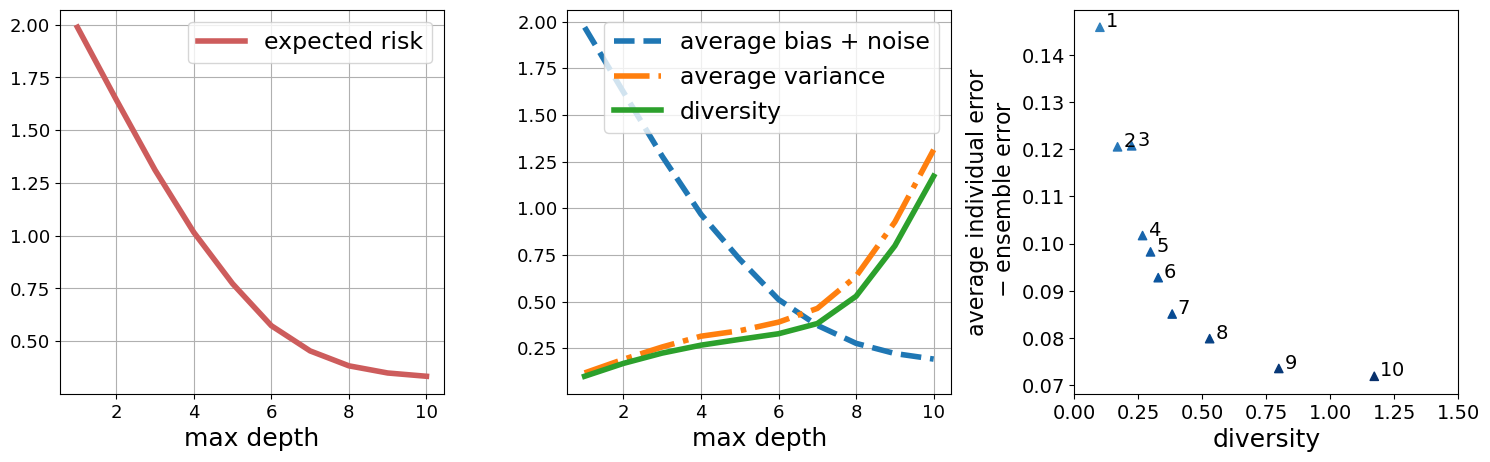

<AxesSubplot: xlabel='max_depth'>

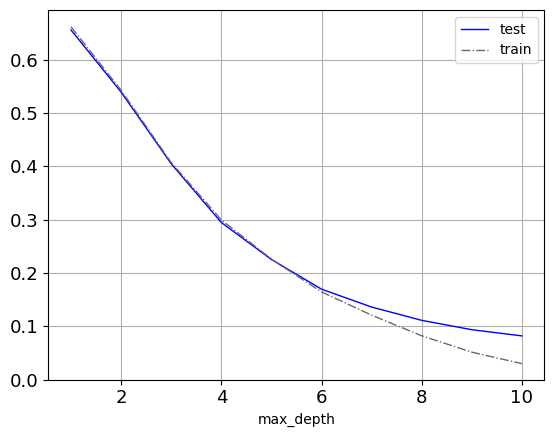

In [31]:
x = np.array(diversities)
#z = np.array(variances)
y = np.zeros_like(diversities)
import matplotlib.ticker as plticker
from scipy.stats import pearsonr
from decompose import plotting_utils


for idx in range(len(diversities)):
    y[idx] = (average_individual_errors_list[idx] - ensemble_errors_list[idx]).mean()


matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)


# fig, ax = plt.subplots(figsize=(8,4))
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

plotting_utils.plot_bvd(bag_results, bias=False, variance=False, diversity=False, axes=ax[0])
plotting_utils.plot_bvd(bag_results, ensemble_risk=False, axes=ax[1])
ax[0].set_xlabel("max depth", fontsize=18)
ax[1].set_xlabel("max depth", fontsize=18)
ax[0].legend(prop = {"size" : 17})
ax[1].legend(prop = {"size" : 17})


bagging_coeff = (np.corrcoef(x[1:20], y[1:20])**2)[0,1]
print(f"Bagging R^2 {bagging_coeff}")


ax[2].scatter(x[:19], y[:19], c=range(21,21+len(x)), label="bagging", cmap="Blues", marker="^", vmin=1)
# ax[0].scatter(z[:19], y[:19], c=range(21,21+len(x)), label="bagging", cmap="Oranges", marker="^", vmin=1)
ax[2].set_xlabel("diversity", fontsize=18)
ax[2].set_ylabel("average individual error\n $-$ ensemble error", fontsize=16)

#FONTSIZE = 12
FONTSIZE=14

for idx in range(10):
    ax[2].annotate(f"${idx + 1}$", (x[idx] + 0.02, y[idx] ), fontsize=FONTSIZE)
    


if DATASET_NAME == "mnist":
    loc = plticker.MultipleLocator(base=.25)
    ax[2].xaxis.set_major_locator(loc)
    ax[2].set_xlim(0, 1.5)


ax[2].tick_params(axis="x", labelsize= 14)
ax[2].tick_params(axis="y", labelsize= 14)
#ax.set_xlim(right=5)
ax[2].set_box_aspect(1)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

plt.tight_layout()
plt.savefig(f"images/scatter_diversity_bagging_vary_depth_{DATASET_NAME}_{N_TRIALS}_trees_v2.pdf",  bbox_inches="tight")
plt.show()


plotting_utils.plot_errors(bag_results)
